![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Tokenización de textos  

En este taller podrán poner en práctica sus conocimientos sobre preprocesamiento de texto (tokenización). El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos detección de toxicidad en comentarios

En este taller se usará el conjunto de datos de detección de toxicidad en comentarios de la base de datos de Kaggle. Cada observación es un comentario que tiene como variable objetivo (target) la probabilidad de ser un comentario tóxico. El objetivo es predecir la toxicidad de cada comentario. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data).

In [1]:
# SUGERIDO: Descomenta la siguiente linea de código si requieres instalar las libreías básicas utilizadas en este notebook
# Si requieres incluir más librerías puedes agregarlas al archivo Semana 4\requirements.txt
# !pip install -r requirements.txt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [32]:
# Importación librerías
import re
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
nltk.download("stopwords")
%matplotlib inline


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sjaramillo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
sw = stopwords.words("english")
wpt=WordPunctTokenizer()

In [5]:
# Carga de datos de archivos .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2025/main/datasets/Toxicity.zip')
df = df[['id','comment_text', 'target']]
df.head()

,id,comment_text,target
0,6101457,What are you talking about? What group do Pete...,0.0
1,5342103,"NO!, Let him, we need a Conservative government.",0.0
2,743361,"Perhaps he took the ""power out of the Cardinal...",0.2
3,551008,"As always, yours is dripping with sarcasm, whi...",0.0
4,865998,The dirty little secret is that the price rang...,0.3


In [6]:
df.shape

(541462, 3)

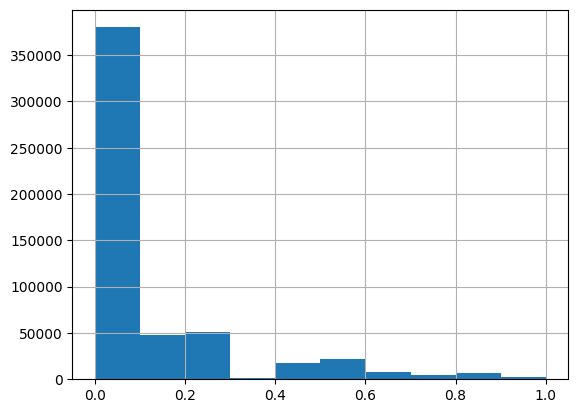

In [7]:
# Impresión histograma de variable de interés (y)
df.target.hist()
plt.show()

In [8]:
# Separación de variable de interés (y)
y = df.target
y.describe()

count    541462.000000
mean          0.102991
std           0.196979
min           0.000000
25%           0.000000
50%           0.000000
75%           0.166667
max           1.000000
Name: target, dtype: float64

In [9]:
# Separación de variables predictoras (X), solo se considera el texto de la noticia
X = df.comment_text

In [10]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Punto 1 - Tokenización con CountVectorizer

En la celda 1 creen y entrenen el modelo de regresión de su preferencia, para que prediga la probabilidad de que un comentario sea tóxico, usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** para preprocesar los comentarios y presenten el desempeño del modelo con la métrica del MSE.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [11]:
# Celda 1
vect_1 = CountVectorizer()
X_dtm_1 = vect_1.fit_transform(X_train)
X_dtm_1_test = vect_1.transform(X_test)
vect_1.vocabulary_

{'oral': 91127,
 'history': 60749,
 'is': 67439,
 'what': 136457,
 'ever': 46583,
 'they': 125107,
 'say': 110750,
 'it': 67682,
 'nazis': 86202,
 'in': 64454,
 'the': 124581,
 '1930': 1649,
 'did': 38596,
 'eugenic': 46371,
 'experiments': 47347,
 'on': 90518,
 'native': 86035,
 'children': 27384,
 'at': 14725,
 'mcgill': 80014,
 'with': 137734,
 'full': 52599,
 'knowledge': 71877,
 'of': 89814,
 'government': 55832,
 'yup': 139920,
 'if': 63495,
 'happened': 58373,
 'who': 136894,
 'are': 13363,
 'we': 135729,
 'to': 126248,
 'didn': 38619,
 'marijuana': 78894,
 'less': 74583,
 'harmful': 58542,
 'human': 62386,
 'health': 59284,
 'than': 124498,
 'cigarettes': 28085,
 'which': 136645,
 'widely': 137099,
 'used': 132446,
 'and': 11703,
 'there': 124961,
 'no': 87715,
 'ban': 16514,
 'reduces': 104654,
 'stress': 120277,
 'aggression': 9490,
 'level': 74674,
 'leading': 73899,
 'crime': 33788,
 'its': 67777,
 'medical': 80457,
 'value': 132943,
 'favorable': 48684,
 'effects': 43479,


In [12]:
X_dtm_1.shape

(362779, 141176)

La matriz resultante presenta dimensiones excesivas para ser procesadas en equipos convencionales. Para poder avanzar en los objetivos de este taller, se adoptarán las siguientes medidas:

1. **Reducción de muestra:** selección de un subconjunto representativo de forma aleatoria
2. **Limpieza de texto:** eliminación de stopwords con el fin de reducir términos de escaso valor para el modelo.
3. **Hiperparametros:** Modificación de los hiperparametros en numero de árboles y máxima profunidad  


In [13]:
df_sample = df.sample(frac=0.05, random_state=42)  # 5% aleatorio reproducible
df_sample.head(10)


,id,comment_text,target
356574,5286156,Interesting ! Sorry to hear of a small busines...,0.000000
471747,5468307,"I will take that into consideration, Motley. I...",0.000000
118328,5352425,I guess after having a somewhat positive portr...,0.000000
142944,353614,According to leading Public Finance and Enviro...,0.000000
496670,6265464,Great. What were you ever even thinking? Now y...,0.000000
278954,708156,That is absolute bull crap. You poke the bear ...,0.800000
129015,5190282,Personally I will not listen to Pro-Abortionis...,0.000000
27042,6262712,I'm not one to think that highly of people in ...,0.166667
308533,5949396,I don't think so.\nThe turning point of the el...,0.200000
180558,5327560,"When reading the article, it seems to say that...",0.000000


In [14]:
df_sample.shape

(27073, 3)

In [15]:
def preprocess_and_clean(doc: str) -> str:
    doc = re.sub(r"[áÁ]", "a", doc)
    doc = re.sub(r"[éÉ]", "e", doc)
    doc = re.sub(r"[íÍ]", "i", doc)
    doc = re.sub(r"[óÓ]", "o", doc)
    doc = re.sub(r"[úÚ]", "u", doc)
    doc = re.sub(r"[^a-zA-Z\s]", " ", doc)
    doc = doc.lower()

    # 4) Tokeniza y filtra:
    #    - tokens de al menos 2 caracteres
    #    - tokens que no estén en sw
    tokens = [
        tok for tok in wpt.tokenize(doc)
        if len(tok) >= 2 and tok not in sw
    ]

    # 5) Reconstruye el texto; si queda vacío, etiqueta como "empty"
    cleaned = " ".join(tokens)
    return cleaned if cleaned.strip() else "empty"


In [16]:
df_sample["comment_text_cleaned"] = df_sample["comment_text"].apply(preprocess_and_clean)

In [34]:
# Separación de variables predictoras (X), solo se considera el texto de la noticia
X = df_sample.comment_text_cleaned
# Separación de variable de interés (y)
y = df_sample.target
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# CountVectorizer
vect_clean = CountVectorizer()
X_dtm_clean = vect_clean.fit_transform(X_train)
X_dtm_clean_test = vect_clean.transform(X_test)
X_dtm_clean.shape


(18138, 34605)

Con la depueración mencionada anteriormente se pudo bajar de 141.176 a 34.605 las columnas de la matriz del CountVectorizer. Con esto, se espera poder ejecutar los modelores de regresión con máquinas convencionales.

In [ ]:
rf_clean = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=2)
rf_clean.fit(X_dtm_clean, y_train)
y_pred_clean = rf_clean.predict(X_dtm_clean_test)
mse_clean = mean_squared_error(y_test, y_pred_clean)
mse_clean

0.0335408783089576

## Punto 2 - Tokenización con CountVectorizer y trigramas

En la celda 2 creen y entrenen el mismo modelo de regresión del punto anterior (es decir si usaron un RandomForestRegresor usen nuevamente ese regresor), para que prediga la probabilidad de que un comentario sea tóxico, usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer **considerando trigramas** para preprocesar los comentarios y presenten el desempeño del modelo con la métrica del MSE.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [20]:
vect_tri = CountVectorizer(ngram_range=(3, 3))
X_dtm_tri = vect_tri.fit_transform(X_train)
X_dtm_tri_test = vect_tri.transform(X_test)
X_dtm_tri.shape


(18138, 439708)

In [ ]:
rf_tri = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=2)
rf_tri.fit(X_dtm_tri, y_train)
y_pred_tri = rf_tri.predict(X_dtm_tri_test)
mse_tri = mean_squared_error(y_test, y_pred_tri)
mse_tri

0.0373401989137409

## Punto 3 - TfidfVectorizer

Investigen sobre la función TfidfVectorizer. En la celda de texto 3, expliquen en qué consiste esta técnica de tokenización (describanla y expliquen su funcionamiento) y cúales son las ventajas o deventajas de su uso al compararlo con la función CountVectorizer.

### TF-IDF

Una de las principales desventajas de las bolsas de palabras es que asumen que todos los términos tienen igual importancia. No obstante, existen dos casos en los que algunos términos deberían tener mayor o menor importancia:

1. Palabras comunes que aparecen en todos los documentos y no aportan mucha información para distinguir un documento de otro. 
2. Términos únicos y poco frecuentes que son sumamente relevantes para distinguir algunos documentos en específico.

En este ámbito, surge la necesidad de estrategias que permitan capturar este tipo de relaciones. Una de las soluciones más comunes es **term frequency - inverse document frequency (TF-IDF)**. Se trata de un método que fue propuesto como métrica para la evaluación de resultados en motores de búsqueda y se convirtió en un estándar dentro de los sistemas de recuperación de información.

**TF-IDF** amplía la idea de bolsas de palabras al ponderar cada término $t_i$ por un peso $w_{i}$ como se muestra a continuación:

$$
\text{TFIDF}(t_i | d_j) = \text{TF}(t_i|d_j) \cdot w_i
$$

Con esto, se puede asignar un peso menor a aquellos términos comunes entre documentos y un peso mayor a aquellos términos poco frecuentes. Una de las formas más comunes para determinar estos pesos es con la **frecuencia inversa de documento** $w_{idf}(t_i)$ que se calcula de la siguiente forma:

$$
w_i = 1 + \log{\frac{N}{1 + \text{df}(t_i)}}
$$

Donde $N$ es el número de documentos en el corpus y $\text{df}(t_i)$ es el número de documentos en los que se encuentra el término $t_i$.

Adicionalmente, una extención de TF-IDF consiste en un cambio de escala de la matriz de términos, con esto, se busca atenuar el impacto que tienen los términos que aparecen muchas veces en un documento. Esto se consigue utilizando *sub-linear scaling* $wf(\mathbf{Tf}(t_i,d_j))$ y consiste en transformar las ocurrencias a una escala logarítmica donde los valores grandes se ven atenuados:

$$
wf(\text{TF}(t_i|d_j)) = \left\{
\begin{array}{cl}
1+\log{\text{TF}(t_i|d_j)}      & \mathrm{si\ } \text{TF}(t_i|d_j) > 0 \\
0 & \mathrm{si\ } \text{TF}(t_i|d_j) \le 0 \\
\end{array}
\right.
$$

Finalmente, una versión de TF-IDF con *sub-linear scaling* se muestra a continuación:

$$
tfidf_{2}(t_i|d_j) = wf(\text{TF}(t_i|d_j)) w_i
$$

## Ventajas clave de TF‑IDF

- **Mejor ponderación de los términos**
  - Evita que palabras muy frecuentes (p.ej. “el”, “de”, “y”).
  - Da más peso a términos poco frecuentes y potencialmente más informativos.

- **Normalización**
  - Documentos de distinta longitud pasan a ser comparables.

- **Sub‑linear scaling**
  - Opcionalmente atenúa el efecto de conteos muy altos, ayudando a mitigar outliers de frecuencia.


## Desventajas de TF‑IDF

- **Mayor complejidad y coste**
  - Es necesario hacer todo el BoW para luego hacer la ponderación

- **Difícil actualización incremental**
  - Con nuevos documentos cambia el IDF global; requiere recalcular para mantener consistencia.

- **Puede sobreponderar términos muy poco frecuentes**
  - Palabras poco frecuentes pueden recibir peso alto aunque quizá no aporten generalización.




In [ ]:
# Ejemplo
from sklearn.feature_extraction.text import TfidfVectorizer

docs = [
    "Los estudiantes estudian en la biblioteca",
    "En la biblioteca los estudiantes estudian",
    "Estudiantes en la biblioteca estudian",
]

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(docs)

df_tfidf = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=[f"Doc{i+1}" for i in range(len(docs))]
)
df_tfidf

,biblioteca,en,estudian,estudiantes,la,los
Doc1,0.387547,0.387547,0.387547,0.387547,0.387547,0.499037
Doc2,0.387547,0.387547,0.387547,0.387547,0.387547,0.499037
Doc3,0.447214,0.447214,0.447214,0.447214,0.447214,0.000000


## Punto 4 - Tokenización con TfidfVectorizer

En la celda 4 creen y entrenen el mismo modelo de regresión del primer punto, para que prediga la probabilidad de que un comentario sea tóxico, usando los set de entrenamiento y test definidos anteriormente. Procesen los comentarios con la función **TfidfVectorizer** y presenten el desempeño del modelo con la métrica del MSE.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [35]:
# Celda 4
tfidf = TfidfVectorizer()
X_tfidf_train = tfidf.fit_transform(X_train)
X_tfidf_test = tfidf.transform(X_test)
X_tfidf_train.shape

(18138, 34605)

In [36]:
rf_tfidf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=2)
rf_tfidf.fit(X_tfidf_train, y_train)
y_pred_tfidf = rf_tfidf.predict(X_tfidf_test)
mse_tfidf = mean_squared_error(y_test, y_pred_tfidf)
mse_tfidf

0.033451194234408066

## Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos y comenten cómo el preprocesamiento de texto afecta el desempeño.

In [ ]:
# Celda 5 Código para graficos y tablas comparativas


In [ ]:
### Punto 5.1 - Comparación y análisis de resultados
